In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_12_24_WMH_CorrectedMultiAnno'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True,
)

Finished loading inference stats.
Log amounts: root                                                                                               log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_12_24_WMH_CorrectedMultiAnno/WMH_Individual_Uncalibrated  20240612_131422-VVCX-4ecf6af77248dab32e1db67d8c7b2eb9    19798
                                                                                                   20240612_131426-DX10-fe461e30adb1c92c51d995bc0722d430    19798
                                                                                                   20240612_131431-O95X-41cfc2f330caa739309586d342b974f7    19798
                                                                                                   20240612_131435-GTFK-1396238a9a59eb36e9f07567b46de25d    19798
                                                                                                   20240612_131438-WWCQ-4c9f0dd9f1e4acc37d95159ef216dc3c

In [4]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "annotator",
    "data_id",
    "gt_volume",
    "hard_volume",
    "soft_volume",
    "pretrained_seed", 
    "slice_idx",
    "split",
    "task"
]
# Take these columns of the inference_df, drop other columns.
experiment_df = inference_df[exp_columns]
# Remove the duplicate rows.
experiment_df = experiment_df.drop_duplicates()

In [5]:
# Accumulate the volumes.
volume_df = experiment_df.groupby(["data_id", "annotator", "task", "pretrained_seed", "split"]).agg(
    gt_volume=("gt_volume", "sum"),
    hard_volume=("hard_volume", "sum"),
    soft_volume=("soft_volume", "sum"),
).reset_index()

In [6]:
def prepare_error_df(raw_df, groupby_keys):
    # Make a clone of the volume df.
    input_df = raw_df.copy()
    # Make two new columns, one for the soft volume error and one for the hard volume error.
    input_df['soft_volume_error'] = input_df['soft_volume'] - input_df['gt_volume']
    input_df['hard_volume_error'] = input_df['hard_volume'] - input_df['gt_volume']
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=["soft_volume_error", "hard_volume_error"],
        var_name="volume_type",
        value_name="error",
    )
    # Make some columns that are useful for plotting.
    error_df['abs_error'] = error_df['error'].abs()
    error_df['log_abs_error'] = error_df['error'].abs().apply(lambda x: np.log(x + 1))
    # Return the melted dataframe.
    return error_df

# Experiment 1: Looking at one annotator on Amsterdam, let's look at how the volumetric comparison looks like.

In [7]:
# Make some columns that are useful for plotting.
melted_error_df = prepare_error_df(volume_df, groupby_keys=["annotator", "data_id", "pretrained_seed", "task", "gt_volume", "soft_volume", "hard_volume"])

In [8]:
exp_1_df = melted_error_df.select(annotator='observer_o12', task='Amsterdam')

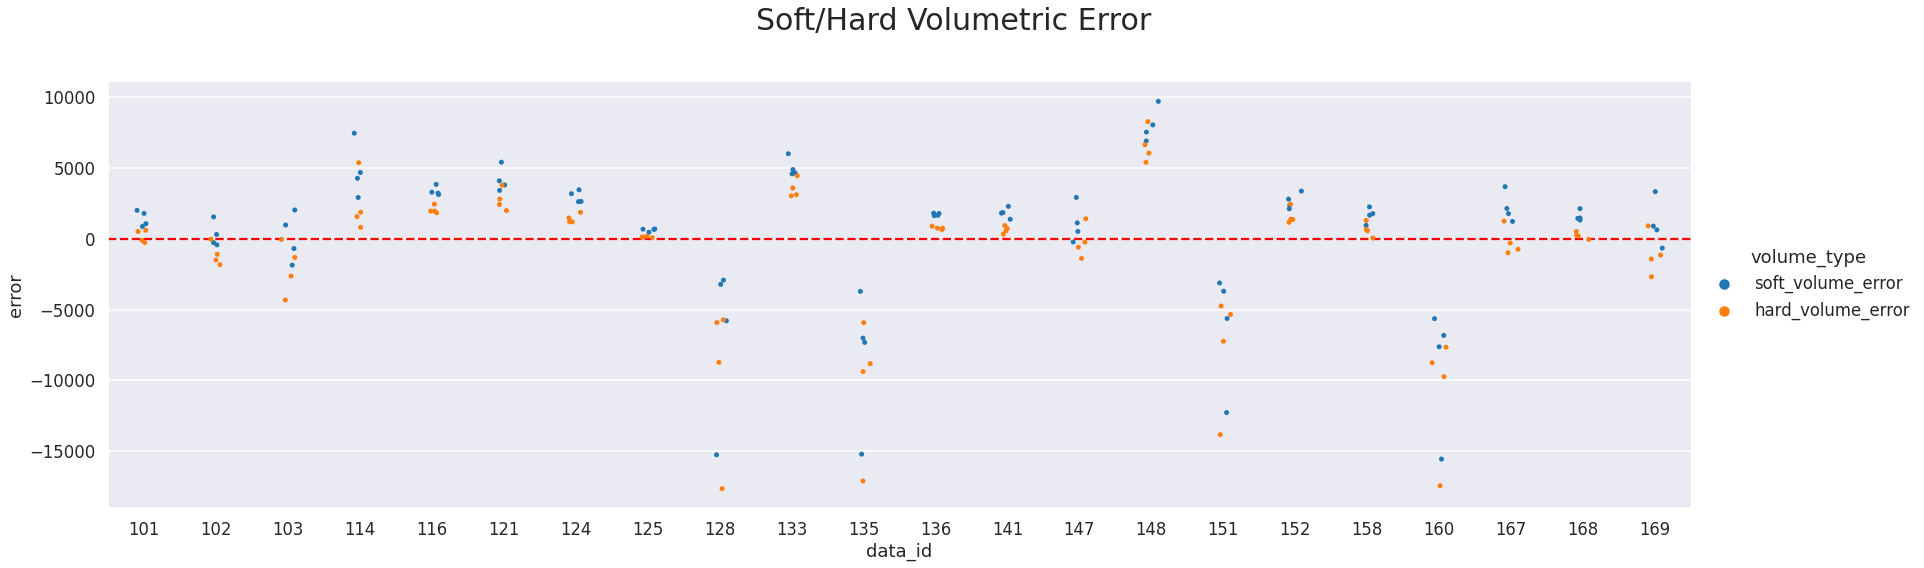

In [9]:
g = sns.catplot(
    exp_1_df,
    x="data_id",
    y="error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

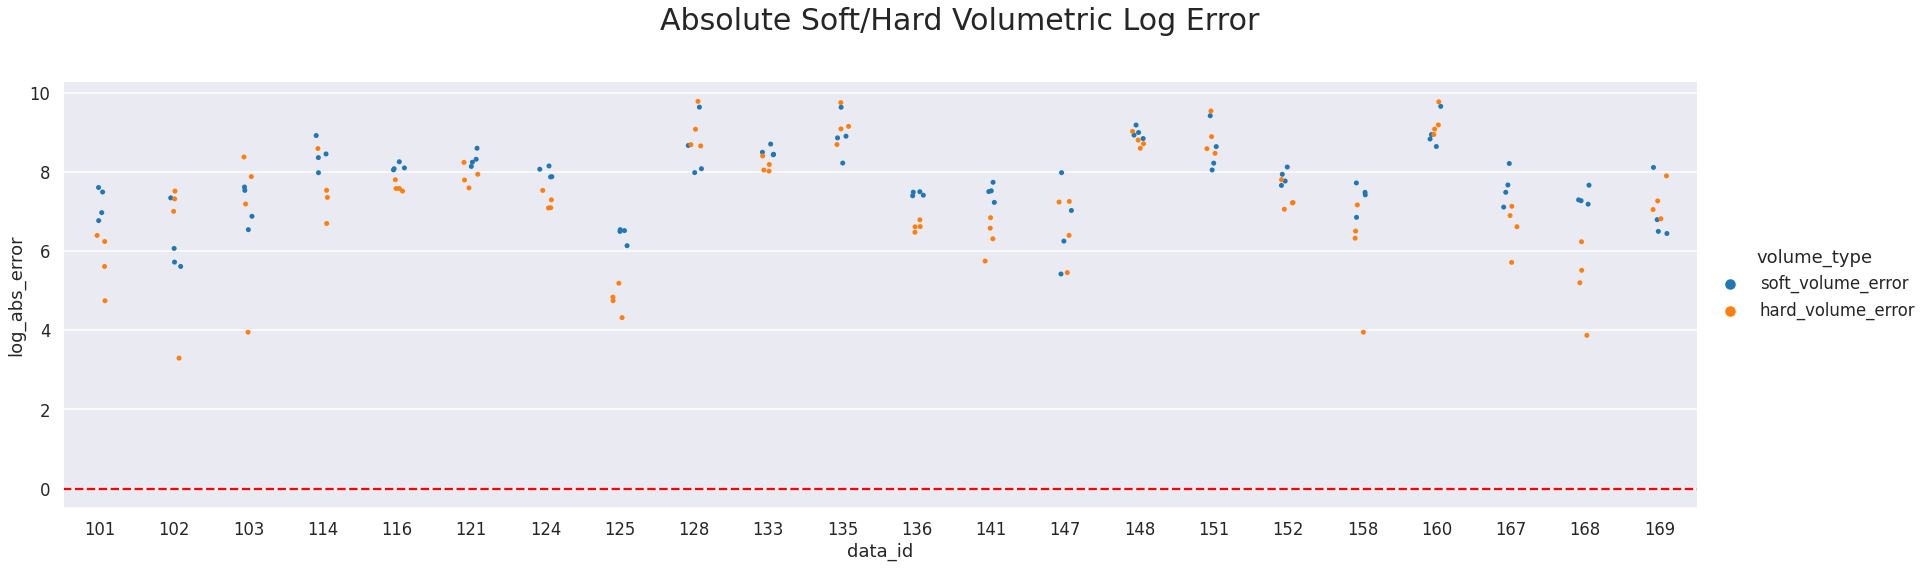

In [10]:
g = sns.catplot(
    exp_1_df,
    x="data_id",
    y="log_abs_error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Soft/Hard Volumetric Log Error', fontsize=30)

# Show the plot
plt.show()

# Experiment 2: Let's look at the same thing but this time also for Singapore.

In [11]:
exp_2_df = melted_error_df.select(annotator='observer_o12', task='Singapore')

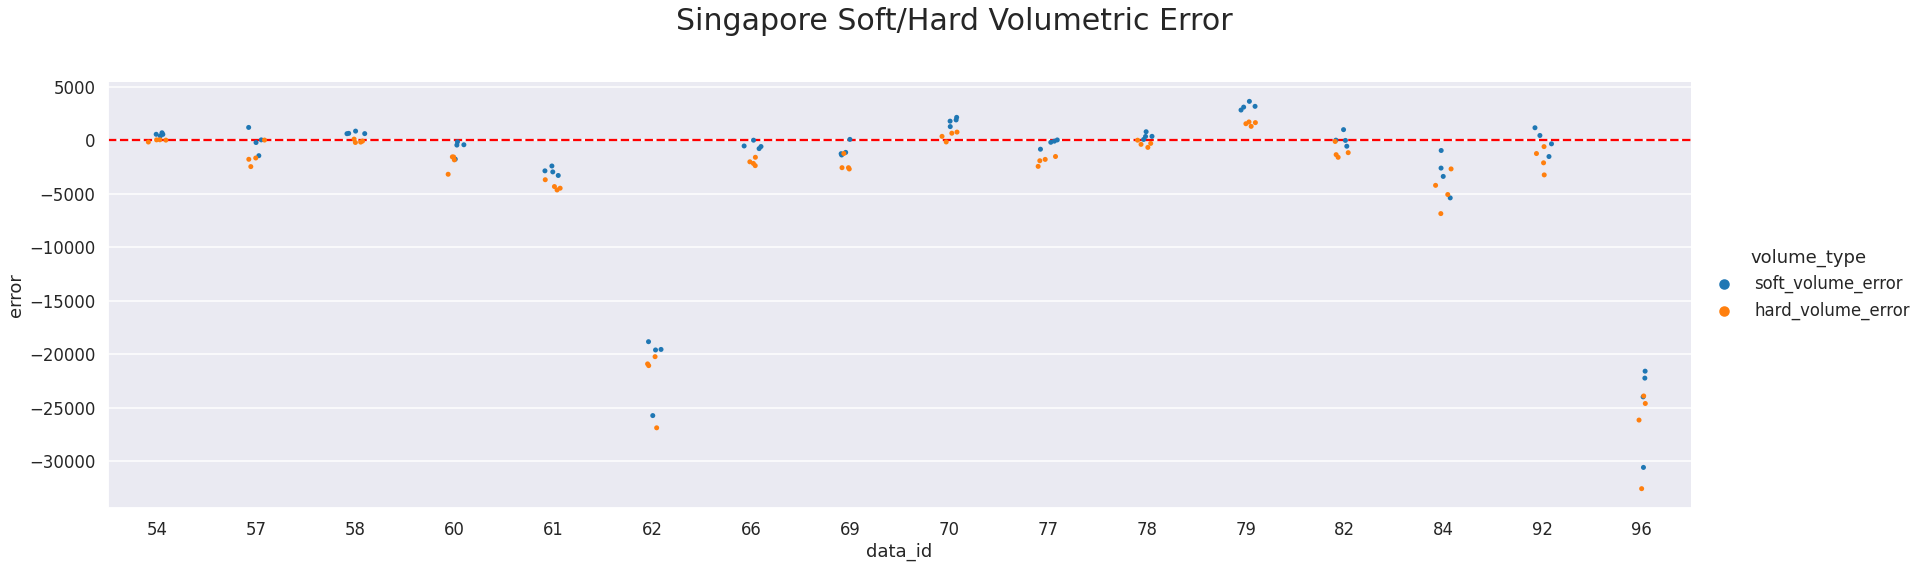

In [12]:
g = sns.catplot(
    exp_2_df,
    x="data_id",
    y="error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Singapore Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

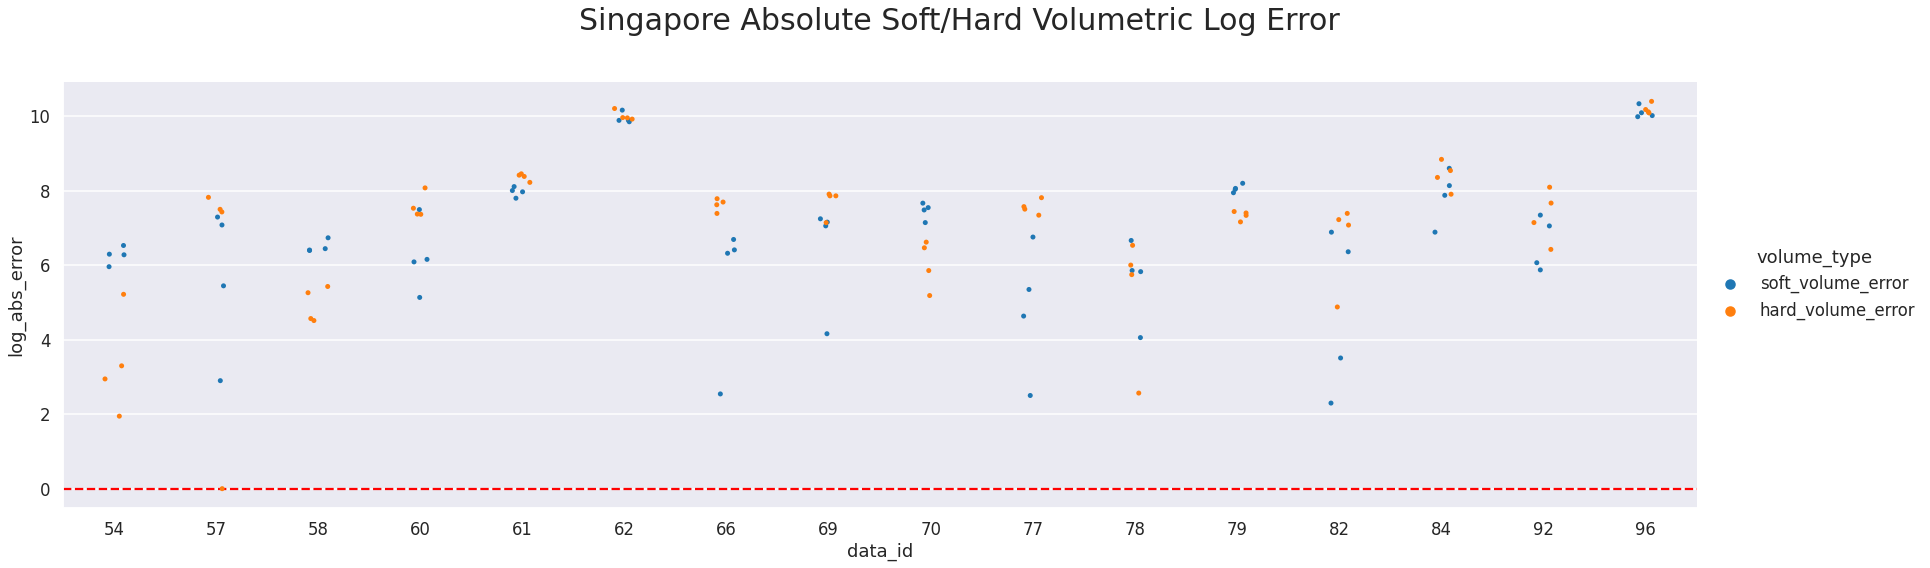

In [13]:
g = sns.catplot(
    exp_2_df,
    x="data_id",
    y="log_abs_error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Singapore Absolute Soft/Hard Volumetric Log Error', fontsize=30)

# Show the plot
plt.show()

# Experiment 3: The interesting thing about WMH is that we have multiple annotations per data_id (for some of the data_ids). Let's gather all of the data_ids that have all three annotators.

In [14]:
# Step 1: Group by 'data_id' and count unique 'annotator' values
unique_counts = volume_df.groupby('data_id')['annotator'].nunique()
# Step 2: Filter 'data_id's that have exactly three unique 'annotator' values
filtered_data_ids = unique_counts[unique_counts == 3].index
# Step 3: Get the subset of rows with the filtered 'data_id's
multiann_vol_df = volume_df[volume_df['data_id'].isin(filtered_data_ids)]

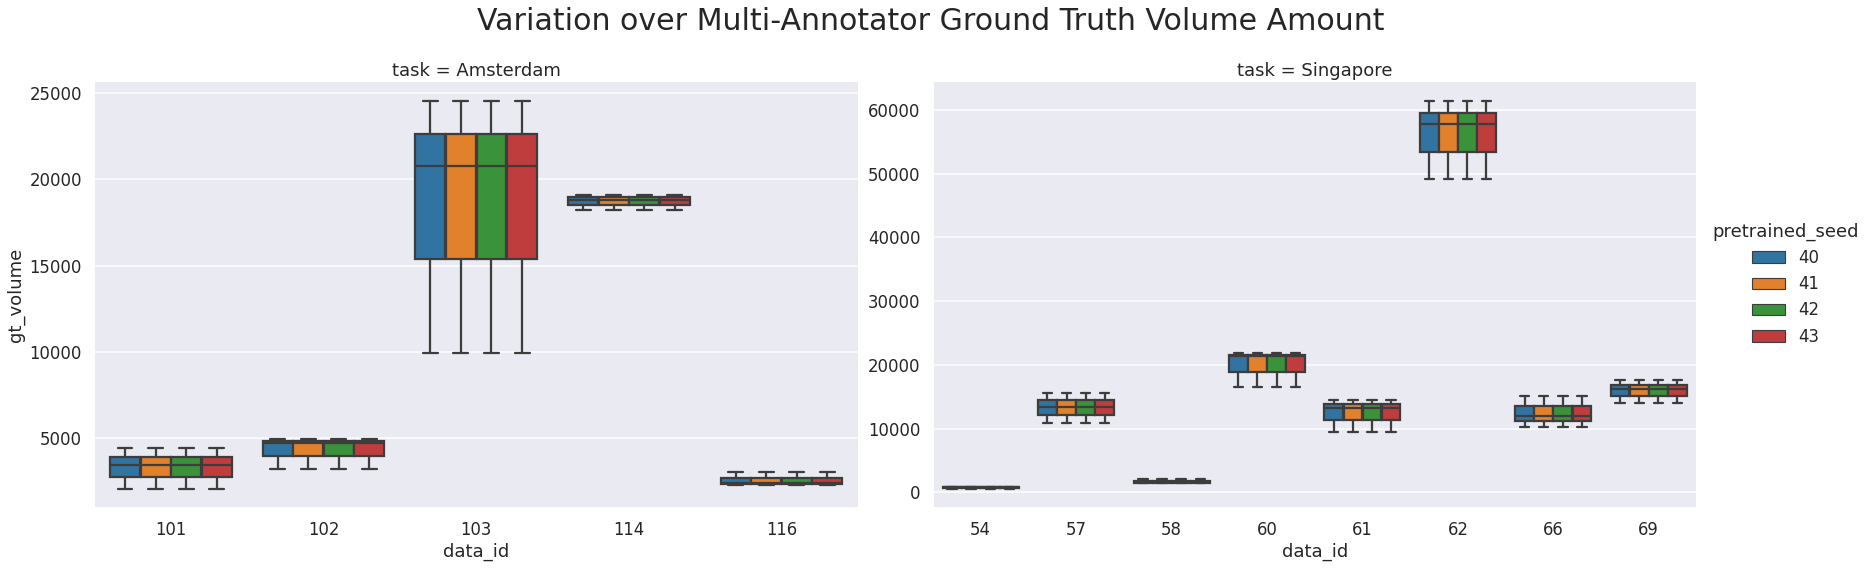

In [15]:
g = sns.catplot(
    multiann_vol_df,
    x="data_id",
    y="gt_volume",
    hue="pretrained_seed",
    col="task",
    kind="box",
    aspect=1.5,
    height=8,
    sharey=False,
    sharex=False,
)

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Variation over Multi-Annotator Ground Truth Volume Amount', fontsize=30)

# Show the plot
plt.show()

In [16]:
MA_df = multiann_vol_df.groupby(['data_id', 'pretrained_seed', 'split', 'task']).agg(
    gt_volume=("gt_volume", "mean"),
    hard_volume=("hard_volume", "mean"),
    soft_volume=("soft_volume", "mean"),
).reset_index()

In [17]:
MA_error_df = prepare_error_df(MA_df, groupby_keys=["data_id", "pretrained_seed", "task", "gt_volume", "soft_volume", "hard_volume"])

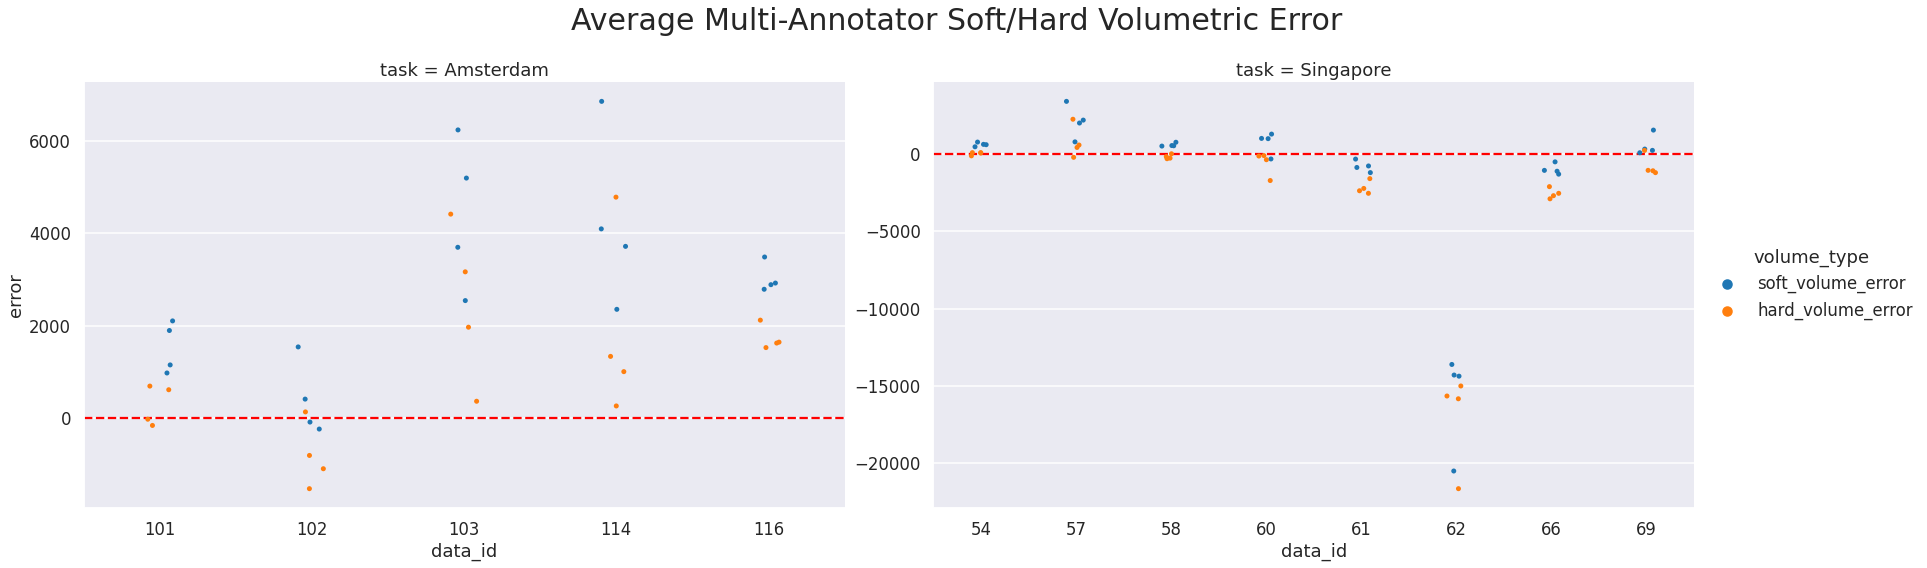

In [18]:
g = sns.catplot(
    MA_error_df,
    x="data_id",
    y="error",
    hue="volume_type",
    col="task",
    aspect=1.5,
    height=8,
    sharey=False,
    sharex=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Average Multi-Annotator Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

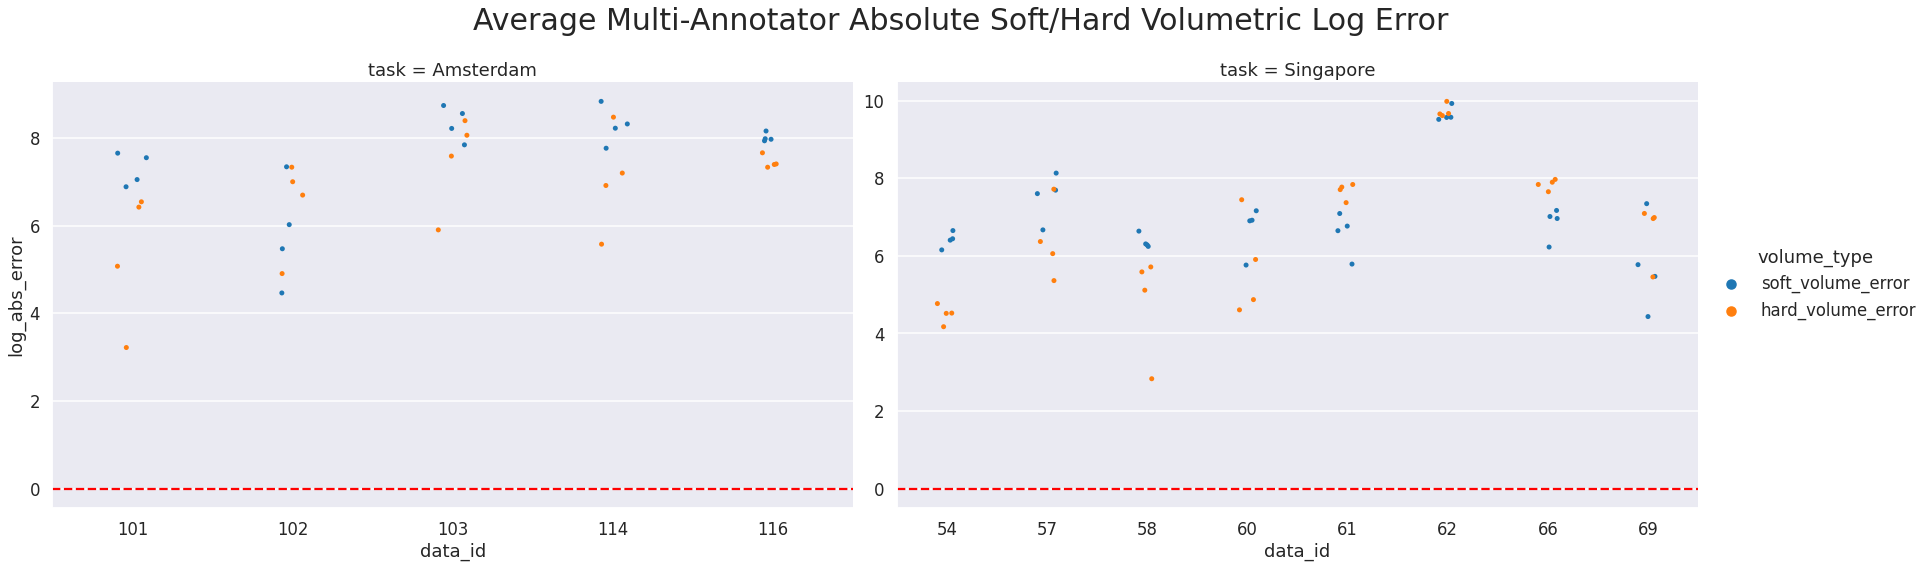

In [19]:
g = sns.catplot(
    MA_error_df,
    x="data_id",
    y="log_abs_error",
    hue="volume_type",
    col="task",
    aspect=1.5,
    height=8,
    sharex=False,
    sharey=False
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Average Multi-Annotator Absolute Soft/Hard Volumetric Log Error', fontsize=30)

# Show the plot
plt.show()